# Transport
In this tutorial we solve a heat transport problem with two wells, one for injection of cold water and one where hot water is produced. We first compute the fluxes $u$ solving a Darcy problem, and then solve the transport problem for the temperature $T$ with and without the diffusive term. <br>

Refer to the tutorial get_started for definitions of geometrical entities, variables and data. As in that example, we choose a unit square domain. For the Darcy problem, we set Dirichlet conditions on the boundary: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$. The boundary value is $p_b = 1000$, whereas the permeability and source term will be defined below. <br>

The transport equation is given by
$$ \frac{\partial T}{\partial t} + u \cdot \nabla T - \nabla \cdot C \nabla T = f_T. $$
$C$ is the (effective) heat conductivity tensor and $f_T$ the heat sources and sinks. The boundary conditions are Dirichlet fixed temperature equal to the initial temperature in the domain. We will use different constant, isotropic values for C and define $f_T$ to be zero except in the two wells. <br>

As usual, we start by importing the required modules:

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Grid creation
We proceed by setting up a cartesian grid:

In [2]:
Nx = Ny = 15                 
g = pp.CartGrid([Nx, Ny], physdims=[15, 15])
g.compute_geometry()

In PorePy, tags indicating grid related quantities may be added directly to the dictionary stored as the grid field tags. We will use this to identify cells for subsequent permeability assignment:

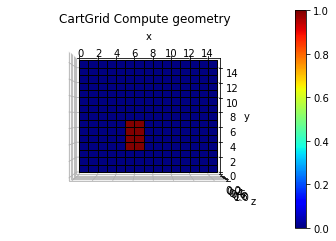

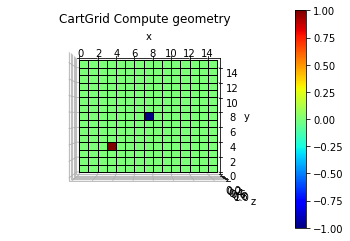

In [3]:
# Pick out the two cells closest to the well locations
i_prod = np.argmin(pp.cg.dist_point_pointset(np.array([4, 4, 0]), g.cell_centers))
i_inj = np.argmin(pp.cg.dist_point_pointset(np.array([8, 8, 0]), g.cell_centers))
g.tags['production_cell'] = np.zeros(g.num_cells, dtype=bool)
g.tags['injection_cell'] = np.zeros(g.num_cells, dtype=bool)
g.tags['production_cell'][i_prod] = 1
g.tags['injection_cell'][i_inj] = 1

# Define a subdomain
Omega_1 = np.ones(g.num_cells, dtype=bool)
Omega_1[g.cell_centers[0, :] < 5] = 0
Omega_1[g.cell_centers[0, :] > 7] = 0
Omega_1[g.cell_centers[1, :] < 3] = 0
Omega_1[g.cell_centers[1, :] > 7] = 0
pp.plot_grid(g, Omega_1)
pp.plot_grid(g, g.tags['production_cell'].astype(float) - g.tags['injection_cell'].astype(float))


## Darcy problem data
We now construct the boundary condition object and two different permeability tensors, and assign parameters. Once again, we refer to get_started for more detailed explanations.

In [4]:
# Permeability

k = 1e-2 * np.ones(g.num_cells)
k[Omega_1] = 1e-5
perm = pp.SecondOrderTensor(3, k)                              

f_flow = np.zeros(g.num_cells)
injection_volume = 10
production_volume = - injection_volume
f_flow[g.tags['injection_cell']] = injection_volume
f_flow[g.tags['production_cell']] = production_volume

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
labels = np.array(['dir']*b_faces.size)
bc_flow = pp.BoundaryCondition(g, b_faces, labels)

bc_values_flow = np.zeros(g.num_faces)
top = b_faces[g.face_centers[1, b_faces] == 1]
bc_values_flow[b_faces] = 1e3

# Parameters
param = pp.Parameters(g)
param.set_tensor("flow", perm)
param.set_bc("flow", bc_flow)
param.set_bc_val("flow", bc_values_flow)
param.set_source("flow", f_flow)
data = {'param': param}


## Transport problem data

We add the transport data to the same parameter object, using the physics keyword "transport". The use of different physics keywords enables the discretizers to pick the right data. We also initialize the heat solution.

In [5]:
# Heat conductivity
c_heat = 5e-2 * np.ones(g.num_cells)
#k[Omega_1] = 1e-4
conductivity = pp.SecondOrderTensor(3, c_heat )

injection_t = .1
f = np.zeros(g.num_cells)
f[g.tags['injection_cell']] =  injection_t * injection_volume 

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
bc = pp.BoundaryCondition(g, b_faces, labels)

bc_values = np.zeros(g.num_faces)
top = b_faces[g.face_centers[1, b_faces] == 1]
bc_values[b_faces] = 1

param.set_tensor("transport", conductivity)
param.set_bc("transport", bc)
param.set_bc_val("transport", bc_values)
param.set_source("transport", f)

## Discretization and solution
We now discretize and solve the two problems using the two-point flux approximation:

In [6]:
flow_discretizer = pp.Tpfa("flow")

A, b = flow_discretizer.matrix_rhs(g, data)
source_discretizer = pp.Integral("flow")
_, b_source = source_discretizer.matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b + b_source)

data['discharge'] = data['flux'] * p + data['bound_flux'] \
* param.get_bc_val('flow')

Define discretizers for the three terms of the transport equation.

In [7]:
diffusion_discretizer = pp.Tpfa("transport")
advection_discretizer = pp.Upwind("transport")
source_discretizer = pp.Integral("transport")
data['deltaT'] = .8 * advection_discretizer.cfl(g, data)
M, _ = pp.MassMatrix().matrix_rhs(g, data)

n_steps = 100

Solve the purely advective transport problem for a constant flow field with an explicit Euler time discretization:

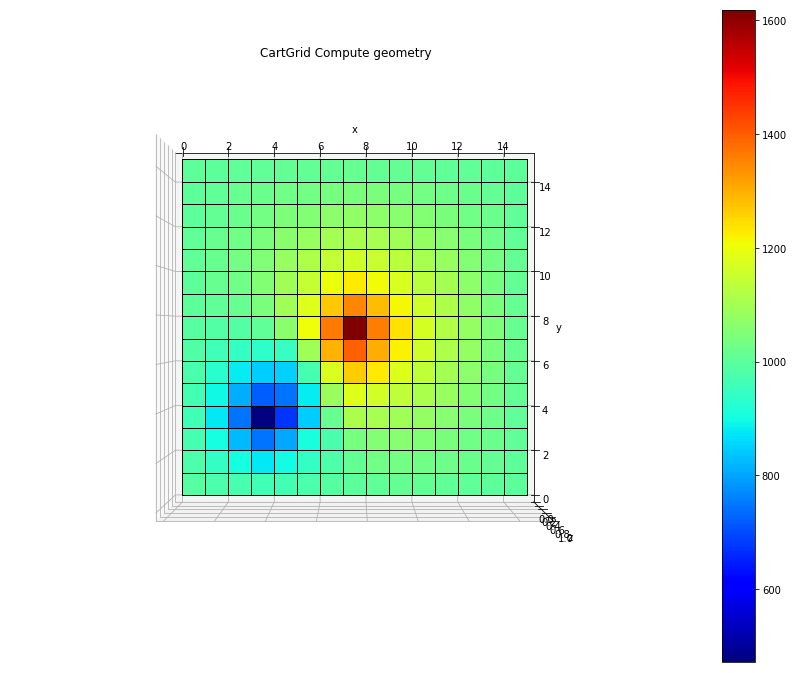

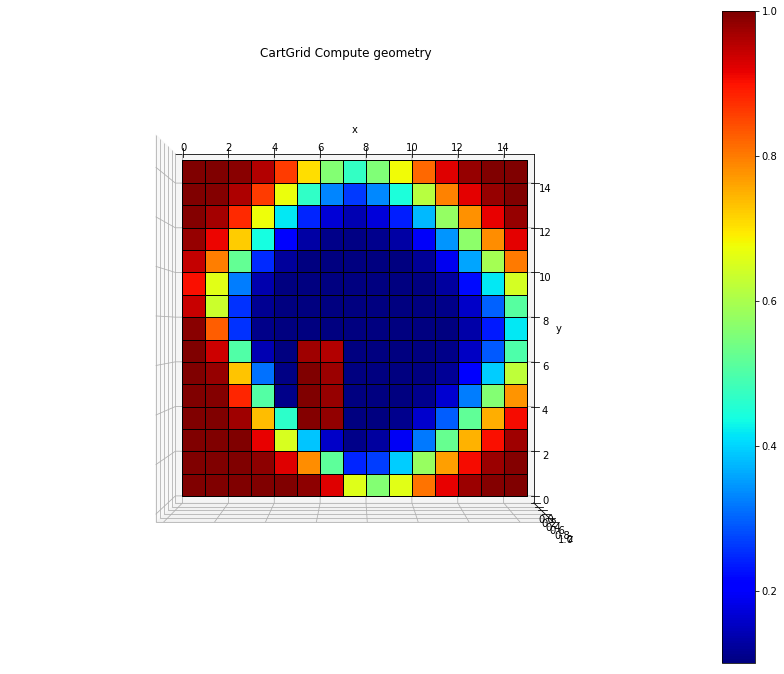

In [8]:
t = np.ones(g.num_cells)

for timestep in range(n_steps):
    f[g.tags['production_cell']] = t[g.tags['production_cell']] * production_volume
    A_adv, b_adv = advection_discretizer.matrix_rhs(g, data)
    _, b_source = source_discretizer.matrix_rhs(g, data)
    lhs = M
    rhs = (M - A_adv) * t + b_adv + b_source
    t = sps.linalg.spsolve(lhs.tocsc(), rhs)
    
pp.plot_grid(g, p, figsize=(15, 12))
pp.plot_grid(g, t, figsize=(15, 12))
# Consistency check on the solution:
assert np.isclose(np.sum(p), 233956.451043)
assert np.isclose(np.sum(t), 118.765683547)

Repeat the transport simulation with diffusion.

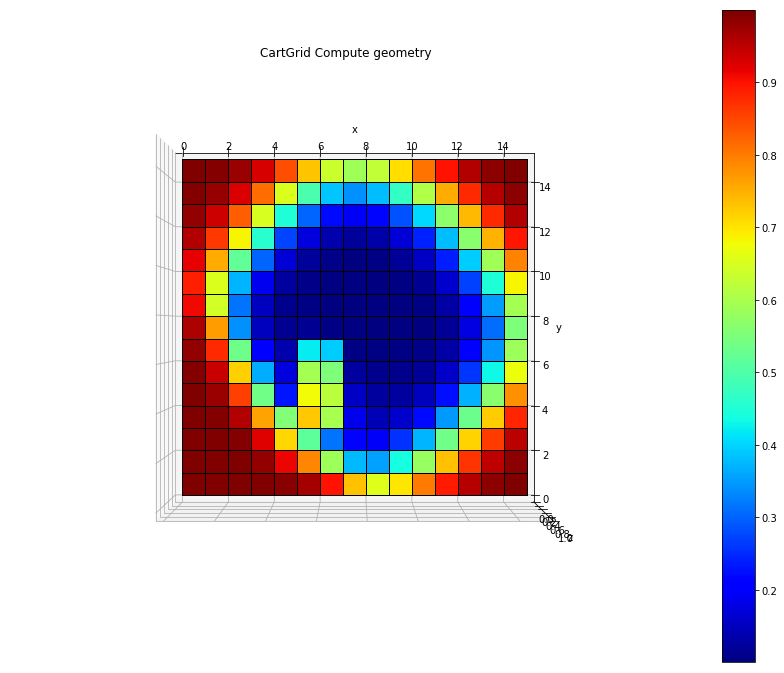

In [9]:
t = np.ones(g.num_cells)
A_diff, b_diff = diffusion_discretizer.matrix_rhs(g, data)

for timestep in range(n_steps):
    f[g.tags['production_cell']] = t[g.tags['production_cell']] * production_volume
    A_adv, b_adv = advection_discretizer.matrix_rhs(g, data)
    _, b_source = source_discretizer.matrix_rhs(g, data)
    lhs = M
    rhs = (M - A_adv - A_diff) * t + b_adv + b_source + b_diff
    t = sps.linalg.spsolve(lhs.tocsc(), rhs)   

pp.plot_grid(g, t, figsize=(15, 12))
# Consistency check on the solution:
assert np.isclose(np.sum(t), 119.233869808)